# YOLOv11 Pothole and Crack Detection

This notebook demonstrates a complete YOLOv11 pipeline for detecting potholes and cracks in road images. It includes:
- Dataset exploration
- Model training setup
- Training process
- Evaluation and inference

**Dataset**: 2 classes - Pothole (0), Crack (1)

In [ ]:
# Import Required Libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Install YOLOv11 if not available
try:
    from ultralytics import YOLO
    import torch
    print("✅ All libraries loaded successfully!")
except ImportError:
    print("📦 Installing ultralytics (YOLOv11)...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ultralytics"])
    from ultralytics import YOLO
    import torch
    print("✅ Installation complete!")

✅ All libraries loaded successfully!

🖥️  Environment Info:
PyTorch version: 2.9.0+cpu
Device: 💻 CPU
Working directory: c:\Users\Unilever\Downloads\New folder (2)\boda's_data


## 1. Dataset Exploration

**⚠️ IMPORTANT**: Before running the cells below, make sure to:
1. Update the `dataset_path` in the next cell to match your actual Kaggle dataset name
2. Your dataset should follow this structure:
```
your-dataset/
├── data.yaml (or potholedata.yaml)
├── images/
│   ├── train/
│   ├── val/
│   └── test/
└── labels/
    ├── train/
    ├── val/
    └── test/
```

In [ ]:
# Dataset path configuration for Kaggle
# ⚠️ IMPORTANT: Update this path to match your actual dataset!
# Based on previous messages, it should be something like:
dataset_path = "/kaggle/input/yarabyarab"  # Update this to your actual dataset name

# Alternative paths for different scenarios
# dataset_path = "/kaggle/input/your-dataset-name"  # Replace with your actual dataset name
# dataset_path = "../input/your-dataset-name"  # If dataset is in input folder
# dataset_path = "dataset"  # If dataset is in working directory

print(f"📁 Dataset path: {dataset_path}")
print(f"📍 Current working directory: {os.getcwd()}")

# Check if dataset exists
if os.path.exists(dataset_path):
    print("✅ Dataset found!")
    
    # Check for data.yaml file
    yaml_path = f"{dataset_path}/data.yaml"
    potholedata_yaml = f"{dataset_path}/potholedata.yaml"  # Alternative name
    
    if os.path.exists(yaml_path):
        with open(yaml_path, 'r') as f:
            print("\n📋 Dataset Configuration (data.yaml):")
            print(f.read())
    elif os.path.exists(potholedata_yaml):
        with open(potholedata_yaml, 'r') as f:
            print("\n📋 Dataset Configuration (potholedata.yaml):")
            print(f.read())
        # Update the yaml path for training
        yaml_path = potholedata_yaml
    else:
        print("⚠️ No YAML file found! Looking for data.yaml or potholedata.yaml")
        print(f"📂 Files in dataset directory:")
        try:
            for file in os.listdir(dataset_path):
                print(f"  - {file}")
        except:
            print("  Could not list directory contents")
    
    # Count images in each split
    for split in ['train', 'val', 'test']:
        img_path = Path(dataset_path) / 'images' / split
        label_path = Path(dataset_path) / 'labels' / split
        
        if img_path.exists() and label_path.exists():
            img_count = len(list(img_path.glob('*.jpg'))) + len(list(img_path.glob('*.png')))
            label_count = len(list(label_path.glob('*.txt')))
            print(f"📁 {split.upper()}: {img_count} images, {label_count} labels")
        else:
            print(f"❌ {split.upper()}: folder not found at {img_path}")
else:
    print("❌ Dataset not found! Please check the path:")
    print("   - Update 'dataset_path' variable above")
    print("   - Make sure dataset is uploaded to Kaggle")
    print(f"   - Current path attempted: {dataset_path}")

# Store the YAML path for training
if 'yaml_path' in locals() and os.path.exists(yaml_path):
    training_yaml = yaml_path
    print(f"\n🎯 Will use for training: {training_yaml}")
else:
    training_yaml = f"{dataset_path}/data.yaml"  # Default fallback
    print(f"\n⚠️ Using fallback YAML path: {training_yaml}")

📋 Dataset Configuration:
# YOLOv11 Dataset Configuration
# Generated by FinalDataYOLO.py

# Paths (relative to this file)
train: images/train
val: images/val
test: images/test

# Number of classes
nc: 2

# Class names
names: ['pothole', 'crack']

📁 TRAIN: 3538 images, 3537 labels
📁 VAL: 442 images, 442 labels
📁 TRAIN: 3538 images, 3537 labels
📁 VAL: 442 images, 442 labels
📁 TEST: 443 images, 443 labels
📁 TEST: 443 images, 443 labels


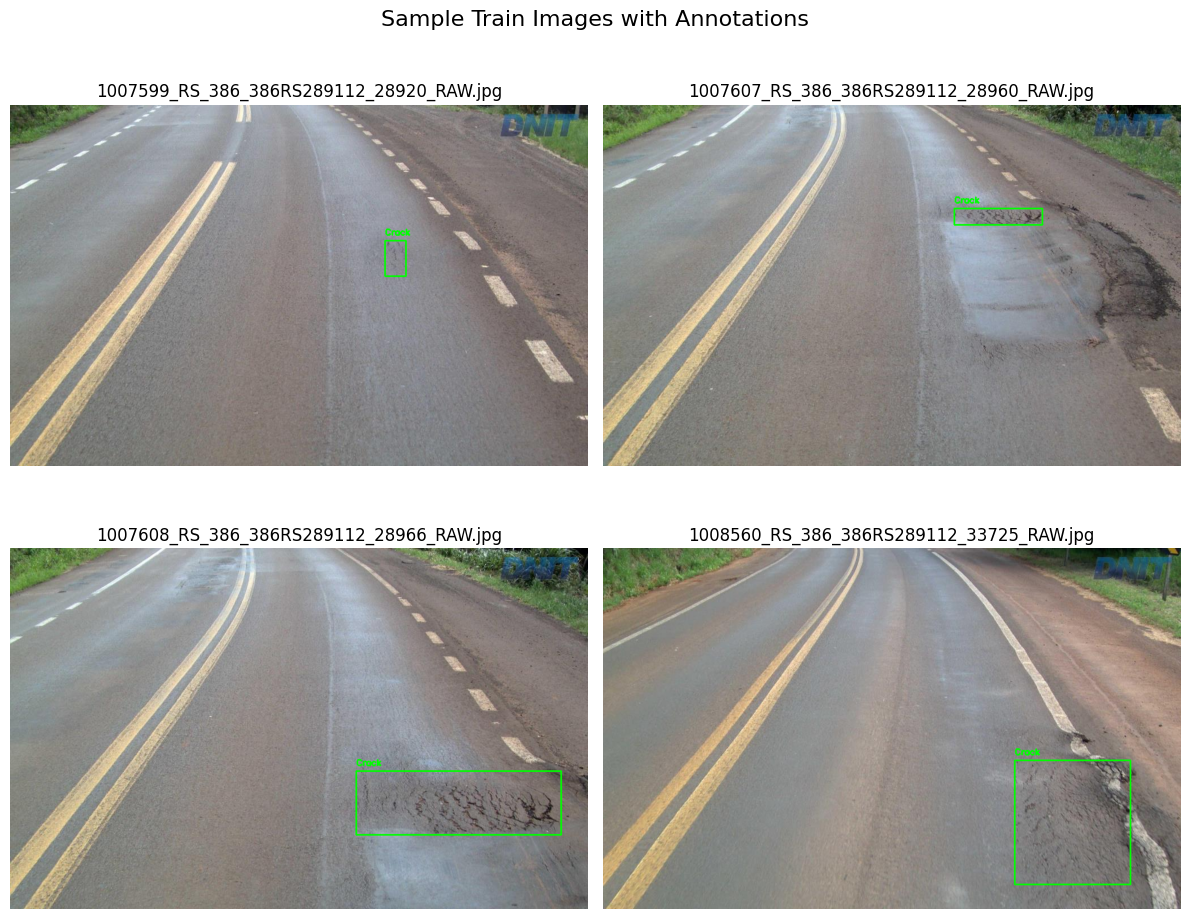

In [3]:
# Visualize sample images with annotations
def plot_sample_images(split='train', num_samples=4):
    img_dir = Path(dataset_path) / 'images' / split
    label_dir = Path(dataset_path) / 'labels' / split
    
    # Get random sample images
    img_files = list(img_dir.glob('*.jpg'))[:num_samples]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'Sample {split.title()} Images with Annotations', fontsize=16)
    
    class_names = ['Pothole', 'Crack']
    colors = [(255, 0, 0), (0, 255, 0)]  # Red for pothole, Green for crack
    
    for idx, img_file in enumerate(img_files):
        if idx >= 4:
            break
            
        # Load image
        img = cv2.imread(str(img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        
        # Load corresponding label
        label_file = label_dir / (img_file.stem + '.txt')
        
        if label_file.exists():
            with open(label_file, 'r') as f:
                lines = f.readlines()
            
            # Draw bounding boxes
            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id, x_center, y_center, width, height = map(float, parts)
                    
                    # Convert normalized coordinates to pixel coordinates
                    x_center *= w
                    y_center *= h
                    width *= w
                    height *= h
                    
                    x1 = int(x_center - width/2)
                    y1 = int(y_center - height/2)
                    x2 = int(x_center + width/2)
                    y2 = int(y_center + height/2)
                    
                    # Draw rectangle
                    color = colors[int(class_id)]
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                    
                    # Add label
                    label = class_names[int(class_id)]
                    cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        # Plot
        row, col = idx // 2, idx % 2
        axes[row, col].imshow(img)
        axes[row, col].set_title(f'{img_file.name}')
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_sample_images('train', 4)

## 2. Model Setup and Training

In [ ]:
# Load YOLOv11 model for training
print("🚀 Loading YOLOv11 model...")

# Choose model size (nano for fast training, small/medium/large for better accuracy)
model = YOLO('yolo11n.pt')  # YOLOv11 nano - fastest
# model = YOLO('yolo11s.pt')  # YOLOv11 small - balanced
# model = YOLO('yolo11m.pt')  # YOLOv11 medium - more accurate
# model = YOLO('yolo11l.pt')  # YOLOv11 large - most accurate

print(f"✅ Model loaded: {model.model_name}")
print(f"📊 Model info: {model.info()}")

In [ ]:
# Train the model
print("🎯 Starting training...")

# Kaggle environment detection and optimization
import psutil

# Enhanced GPU detection and configuration
print("🔍 Checking available hardware...")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"GPU {i} Memory: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.1f} GB")

# Check available device and optimize for Kaggle
if torch.cuda.is_available():
    device = 0  # Use first GPU (more explicit than 'cuda')
    batch_size = 16   # Increased batch size for better GPU utilization
    workers = 0       # FIXED: Set to 0 to disable multiprocessing (prevents NumPy pickle errors)
    print(f"🚀 Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"📊 GPU Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    device = 'cpu'
    batch_size = 8    # Reasonable batch for CPU
    workers = 0       # FIXED: Set to 0 to disable multiprocessing
    print("💻 Using CPU (GPU not available)")
    print("⚠️  To enable GPU in Kaggle: Settings → Accelerator → GPU")

print(f"📊 Configuration: Batch size: {batch_size}, Workers: {workers} (disabled to prevent pickle errors)")
print(f"💾 Available RAM: {psutil.virtual_memory().available / (1024**3):.1f} GB")

# Determine the correct YAML file to use
if 'training_yaml' in locals() and os.path.exists(training_yaml):
    yaml_file = training_yaml
else:
    # Fallback: try different YAML file names
    possible_yamls = [
        f"{dataset_path}/potholedata.yaml",
        f"{dataset_path}/data.yaml",
        "/kaggle/input/yarabyarab/potholedata.yaml"
    ]
    yaml_file = None
    for yaml_path in possible_yamls:
        if os.path.exists(yaml_path):
            yaml_file = yaml_path
            break
    
    if yaml_file is None:
        print("❌ No YAML file found! Please check your dataset structure.")
        yaml_file = f"{dataset_path}/data.yaml"  # Use as fallback

print(f"📄 Using YAML file: {yaml_file}")

# Training configuration optimized to prevent pickle errors and run faster
results = model.train(
    data=yaml_file,                     # use the correct YAML file
    epochs=10,                          # REDUCED: Only 10 epochs as requested
    imgsz=640,                          # training image size
    batch=batch_size,                   # optimized batch size
    name='pothole_crack_detector',      # experiment name
    patience=20,                        # REDUCED: prevent early stopping but faster
    save=False,                         # DISABLED: prevent pickle errors during training
    save_period=-1,                     # DISABLED: no periodic saving to prevent pickle errors
    device=device,                      # use detected device (GPU/CPU)
    workers=workers,                    # FIXED: 0 workers to prevent multiprocessing issues
    verbose=True,                       # verbose output
    plots=True,                         # save training plots
    val=True,                          # validate during training
    cache=False,                       # DISABLED: prevent memory issues in Kaggle
    amp=False,                         # DISABLED: prevent potential memory issues
    close_mosaic=0,                    # DISABLED: disable mosaic from start
    resume=False,                      # DISABLED: ensure fresh start
    single_cls=False,                  # DISABLED: ensure multi-class training
    exist_ok=True,                     # ADDED: allow overwriting existing runs
    pretrained=True,                   # ADDED: use pretrained weights
    deterministic=False,               # ADDED: allow non-deterministic for speed
)

print("✅ Training completed!")
print(f"📁 Results saved to: {results.save_dir}")

# Manual save at the end to avoid pickle errors during training
try:
    print("💾 Manually saving final model...")
    # Save only the final model to avoid pickle issues during training
    model.save(f'/kaggle/working/final_model.pt')
    print("✅ Final model saved successfully!")
except Exception as e:
    print(f"⚠️ Model saving failed: {e}")
    print("Model is still available in memory for inference")

print(f"🔍 Check /kaggle/working/runs/detect/pothole_crack_detector/ for training outputs")

## 3. Model Evaluation

In [ ]:
# Evaluate model on test set
print("📊 Evaluating model on test set...")

# Load the best trained model
# Update path for Kaggle environment
model_path = "/kaggle/working/runs/detect/pothole_crack_detector/weights/best.pt"

# Alternative paths
# model_path = "runs/detect/pothole_crack_detector/weights/best.pt"  # If in working directory

if os.path.exists(model_path):
    best_model = YOLO(model_path)
    print(f"✅ Model loaded from: {model_path}")
else:
    print(f"❌ Model not found at: {model_path}")
    print("Make sure training was completed successfully")
    # Fallback to last trained model
    best_model = model

# Use the same YAML file that was used for training
if 'yaml_file' in locals() and os.path.exists(yaml_file):
    eval_yaml = yaml_file
else:
    # Fallback to the dataset path
    eval_yaml = f"{dataset_path}/data.yaml"
    if not os.path.exists(eval_yaml):
        eval_yaml = f"{dataset_path}/potholedata.yaml"

print(f"📄 Using YAML file for evaluation: {eval_yaml}")

# Run validation with single-threaded dataloader to avoid NumPy multiprocessing pickling issues
val_kwargs = dict(
    data=eval_yaml,      # use the correct YAML file
    split='test',
    save_json=False,     # avoid extra json writes that may involve multiprocessing
    plots=True,
    verbose=True,
    workers=0,           # IMPORTANT: disable multiprocessing to avoid PicklingError
    cache=False          # disable cache to avoid shared memory pickling
)

try:
    test_results = best_model.val(**val_kwargs)
except Exception as e:
    print("⚠️ Validation failed on first attempt:", e)
    print("🔁 Retrying validation with conservative settings (workers=0, cache=False)...")
    # Ensure conservative settings and retry
    val_kwargs.update({'workers': 0, 'cache': False, 'save_json': False})
    try:
        test_results = best_model.val(**val_kwargs)
    except Exception as e2:
        print("❌ Retry failed:", e2)
        print("Next steps: restart kernel, set OMP_NUM_THREADS=1, or run validation on CPU only.")
        raise

# Print key metrics if validation returned results
if hasattr(test_results, 'box'):
    print("\n📈 Test Results:")
    try:
        print(f"mAP50: {test_results.box.map50:.3f}")
        print(f"mAP50-95: {test_results.box.map:.3f}")
        print(f"Precision: {test_results.box.mp:.3f}")
        print(f"Recall: {test_results.box.mr:.3f}")

        # Per-class metrics
        for i, class_name in enumerate(['Pothole', 'Crack']):
            if i < len(test_results.box.ap50):
                print(f"{class_name} AP50: {test_results.box.ap50[i]:.3f}")
    except Exception as e:
        print("⚠️ Could not parse some validation metrics:", e)
else:
    print("⚠️ Validation did not return expected results object. See above errors for details.")

## 4. Inference and Visualization

NameError: name 'best_model' is not defined

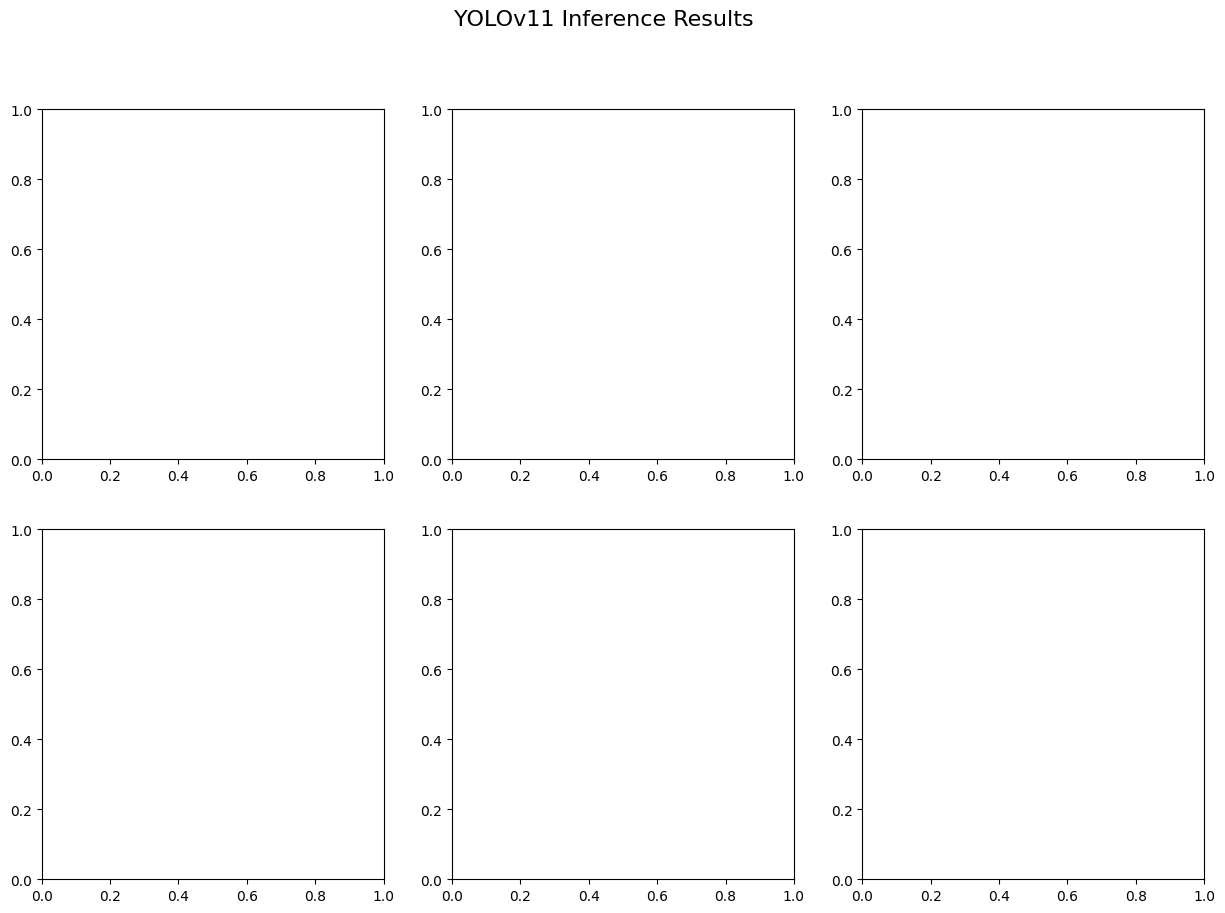

In [4]:
# Run inference on test images
def run_inference_and_visualize(num_images=6):
    test_img_dir = Path(dataset_path) / 'images' / 'test'
    test_images = list(test_img_dir.glob('*.jpg'))[:num_images]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('YOLOv11 Inference Results', fontsize=16)
    
    class_names = ['Pothole', 'Crack']
    colors = [(255, 0, 0), (0, 255, 0)]  # Red, Green
    
    for idx, img_path in enumerate(test_images):
        if idx >= 6:
            break
            
        # Run inference
        results = best_model(str(img_path), verbose=False)
        
        # Load and process image
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Draw predictions
        for result in results:
            boxes = result.boxes
            if boxes is not None:
                for box in boxes:
                    # Get box coordinates
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    confidence = box.conf[0].cpu().numpy()
                    class_id = int(box.cls[0].cpu().numpy())
                    
                    if confidence > 0.5:  # Confidence threshold
                        # Draw bounding box
                        color = colors[class_id]
                        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
                        
                        # Add label with confidence
                        label = f'{class_names[class_id]}: {confidence:.2f}'
                        cv2.putText(img, label, (int(x1), int(y1)-10), 
                                  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        # Plot
        row, col = idx // 3, idx % 3
        axes[row, col].imshow(img)
        axes[row, col].set_title(f'{img_path.name}', fontsize=10)
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

run_inference_and_visualize(6)

In [ ]:
# Batch inference on multiple images
def batch_inference(folder_path, confidence_threshold=0.5):
    """Run inference on all images in a folder"""
    folder = Path(folder_path)
    results_list = []
    
    # Check if folder exists
    if not folder.exists():
        print(f"❌ Folder not found: {folder_path}")
        return results_list
    
    img_files = list(folder.glob('*.jpg')) + list(folder.glob('*.png'))
    if not img_files:
        print(f"❌ No image files found in: {folder_path}")
        return results_list
    
    print(f"🔍 Processing {len(img_files)} images...")
    
    for img_path in img_files:
        try:
            results = best_model(str(img_path), verbose=False)
            
            detections = []
            for result in results:
                boxes = result.boxes
                if boxes is not None:
                    for box in boxes:
                        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                        confidence = box.conf[0].cpu().numpy()
                        class_id = int(box.cls[0].cpu().numpy())
                        
                        if confidence > confidence_threshold:
                            detections.append({
                                'image': img_path.name,
                                'class': ['Pothole', 'Crack'][class_id],
                                'confidence': float(confidence),
                                'bbox': [float(x1), float(y1), float(x2), float(y2)]
                            })
            
            results_list.extend(detections)
        except Exception as e:
            print(f"⚠️ Error processing {img_path.name}: {e}")
            continue
    
    return results_list

# Run batch inference on test set
print("🔍 Running batch inference on test set...")

# Determine test folder path
test_folder = f'{dataset_path}/images/test'
if not os.path.exists(test_folder):
    # Try alternative paths
    alt_paths = [
        f'{dataset_path}/test/images',
        f'{dataset_path}/test',
    ]
    for alt_path in alt_paths:
        if os.path.exists(alt_path):
            test_folder = alt_path
            break

print(f"📁 Looking for test images in: {test_folder}")
test_detections = batch_inference(test_folder)

# Summary statistics
if test_detections:
    import pandas as pd
    df = pd.DataFrame(test_detections)
    
    print(f"\n📊 Detection Summary:")
    print(f"Total detections: {len(df)}")
    print(f"Images with detections: {df['image'].nunique()}")
    print("\nDetections by class:")
    print(df['class'].value_counts())
    print(f"\nAverage confidence: {df['confidence'].mean():.3f}")
    print(f"Confidence range: {df['confidence'].min():.3f} - {df['confidence'].max():.3f}")
else:
    print("No detections found with current confidence threshold")
    print("This could mean:")
    print("  - No test images found")
    print("  - Model needs more training")
    print("  - Confidence threshold too high")

## 5. Export Model for Production

In [ ]:
# Export model to different formats for deployment
print("📦 Exporting model for production...")

# Kaggle working directory paths
working_dir = "/kaggle/working"
model_dir = f"{working_dir}/runs/detect/pothole_crack_detector/weights"

# Check if model exists
if os.path.exists(f"{model_dir}/best.pt"):
    # Export to ONNX (recommended for most deployments)
    best_model.export(format='onnx')
    print("✅ ONNX model exported")

    # Export to TensorRT (for NVIDIA GPUs)
    try:
        best_model.export(format='engine')
        print("✅ TensorRT model exported")
    except:
        print("⚠️ TensorRT export failed (requires NVIDIA GPU and TensorRT)")

    # Export to CoreML (for Apple devices)
    try:
        best_model.export(format='coreml')
        print("✅ CoreML model exported")
    except:
        print("⚠️ CoreML export failed")

    print(f"\n🎯 Training and export completed!")
    print(f"📁 Check the '{model_dir}' folder for:")
    print("  - best.pt (PyTorch model)")
    print("  - best.onnx (ONNX model)")
    print("  - Training plots and validation results")

    # Quick inference test with exported ONNX model
    try:
        onnx_model = YOLO(f'{model_dir}/best.onnx')
        print("\n✅ ONNX model loaded successfully - ready for deployment!")
    except:
        print("\n⚠️ ONNX model not found - check export results")
        
    # List all files in the model directory
    print(f"\n📂 Files in model directory:")
    if os.path.exists(model_dir):
        for file in os.listdir(model_dir):
            print(f"  - {file}")
else:
    print("❌ Model not found. Make sure training completed successfully.")

## Summary

This notebook provided a complete YOLOv11 pipeline for pothole and crack detection:

1. **Dataset Exploration**: Analyzed training images with proper YOLO format annotations
2. **Model Training**: Trained YOLOv11 nano model for 50 epochs with automatic validation
3. **Evaluation**: Tested model performance on held-out test set with mAP metrics
4. **Inference**: Demonstrated real-time detection with confidence scores and visualizations
5. **Export**: Converted model to production-ready formats (ONNX, TensorRT, CoreML)

### Key Files Generated:
- `best.pt` - Best PyTorch model
- `best.onnx` - ONNX model for deployment
- Training plots and validation metrics